In [1]:
!pip install seaborn
import os
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm  # Використовуємо звичайний tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Налаштування
SEED = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-4
EPOCHS = 10
CONFIDENCE_THRESHOLD = 0.95

In [2]:
# Шляхи
DATA_ROOT = Path("dataset_plants_final")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "val"
TEST_DIR = DATA_ROOT / "test"
UNLABELED_DIR = DATA_ROOT / "unlabeled" / "images"

# Визначення класів вручну (щоб гарантувати порядок)
CLASSES = sorted(['healthy', 'sick'])
class_to_idx = {cls_name: i for i, cls_name in enumerate(CLASSES)}
print(f"Класи: {class_to_idx}")

def load_data_paths(root_dir):
    paths = []
    labels = []
    
    # Проходимо по папках healthy/sick
    for class_name in CLASSES:
        class_dir = root_dir / class_name
        if not class_dir.exists():
            continue
            
        # Збираємо всі картинки
        for img_path in class_dir.glob("*.*"):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                paths.append(str(img_path))
                labels.append(class_to_idx[class_name])
                
    return np.array(paths), np.array(labels) # Конвертуємо в numpy для зручного індексування

# Завантажуємо списки файлів
X_train, y_train = load_data_paths(TRAIN_DIR)
X_val, y_val     = load_data_paths(VAL_DIR)
X_test, y_test   = load_data_paths(TEST_DIR)

# Нерозмічені дані (тільки шляхи)
X_unlabeled = []
if UNLABELED_DIR.exists():
    X_unlabeled = [str(p) for p in UNLABELED_DIR.glob("*.*") if p.suffix.lower() in ['.jpg', '.png', '.jpeg']]
X_unlabeled = np.array(X_unlabeled)

print(f"Завантажено: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}, Unlabeled={len(X_unlabeled)}")

Класи: {'healthy': 0, 'sick': 1}
Завантажено: Train=600, Val=200, Test=200, Unlabeled=5000


In [3]:
# Визначаємо трансформації (як і раніше)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_batch(paths, labels, transform, device):
    """
    Ручна функція: 
    1. Відкриває картинки з диску
    2. Застосовує трансформації
    3. Склеює в один тензор
    """
    batch_imgs = []
    batch_labels = []
    
    for i, path in enumerate(paths):
        try:
            # Відкриваємо картинку
            image = Image.open(path).convert("RGB")
            # Трансформуємо
            image = transform(image)
            
            batch_imgs.append(image)
            if labels is not None:
                batch_labels.append(labels[i])
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue
            
    # Стек картинок у тензор (Batch_Size, 3, 224, 224)
    if not batch_imgs: return None, None
    
    X_tensor = torch.stack(batch_imgs).to(device)
    
    if labels is not None:
        y_tensor = torch.tensor(batch_labels, dtype=torch.long).to(device)
        return X_tensor, y_tensor
    else:
        return X_tensor, None

In [4]:
# Створення моделі
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def train_manual(model, X, y, X_v, y_v, epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    n_samples = len(X)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # --- TRAINING ---
        model.train()
        
        # 1. Перемішування (Shuffling) - критично важливо!
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 2. Ручний прохід по батчах
        # range(start, stop, step)
        pbar = tqdm(range(0, n_samples, BATCH_SIZE), desc="Training")
        
        for i in pbar:
            # Вирізаємо шматок списків
            batch_paths = X_shuffled[i : i + BATCH_SIZE]
            batch_lbls  = y_shuffled[i : i + BATCH_SIZE]
            
            # Завантажуємо картинки
            inputs, targets = get_batch(batch_paths, batch_lbls, train_transform, device)
            if inputs is None: continue
            
            # Стандартний PyTorch крок
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # Статистика
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            pbar.set_postfix({'loss': loss.item()})
            
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # --- VALIDATION (теж вручну) ---
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for i in range(0, len(X_v), BATCH_SIZE):
                b_paths = X_v[i : i + BATCH_SIZE]
                b_lbls  = y_v[i : i + BATCH_SIZE]
                
                inp, tar = get_batch(b_paths, b_lbls, val_transform, device)
                if inp is None: continue
                
                out = model(inp)
                _, pred = torch.max(out, 1)
                
                val_total += tar.size(0)
                val_correct += (pred == tar).sum().item()
        
        val_acc = val_correct / val_total
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")
        print("-" * 30)
        
    return history

# Запуск навчання
print("🚀 Start Training (No DataLoaders)...")
history_v1 = train_manual(model, X_train, y_train, X_val, y_val, epochs=5)

🚀 Start Training (No DataLoaders)...
Epoch 1/5


Training: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.227]


 Train Loss: 0.3723 | Train Acc: 0.8350 | Val Acc: 0.8750
------------------------------
Epoch 2/5


Training: 100%|██████████| 19/19 [00:07<00:00,  2.52it/s, loss=0.189] 


 Train Loss: 0.0986 | Train Acc: 0.9733 | Val Acc: 0.8650
------------------------------
Epoch 3/5


Training: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s, loss=0.101] 


 Train Loss: 0.0615 | Train Acc: 0.9817 | Val Acc: 0.8650
------------------------------
Epoch 4/5


Training: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s, loss=0.208]  


 Train Loss: 0.0489 | Train Acc: 0.9850 | Val Acc: 0.8650
------------------------------
Epoch 5/5


Training: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s, loss=0.00657]


 Train Loss: 0.0250 | Train Acc: 0.9917 | Val Acc: 0.8550
------------------------------


In [5]:
def generate_pseudo_labels_manual(model, file_paths, threshold=0.95):
    model.eval()
    pseudo_paths = []
    pseudo_labels = []
    
    print("🔍 Generating Pseudo-labels...")
    
    with torch.no_grad():
        # Ітеруємося з кроком BATCH_SIZE
        for i in tqdm(range(0, len(file_paths), BATCH_SIZE)):
            batch_paths = file_paths[i : i + BATCH_SIZE]
            
            # labels=None, бо їх немає
            inputs, _ = get_batch(batch_paths, None, val_transform, device)
            if inputs is None: continue
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            
            # Фільтруємо результат
            max_probs = max_probs.cpu().numpy()
            preds = preds.cpu().numpy()
            
            for idx in range(len(batch_paths)):
                if max_probs[idx] >= threshold:
                    pseudo_paths.append(batch_paths[idx])
                    pseudo_labels.append(preds[idx])
                    
    return np.array(pseudo_paths), np.array(pseudo_labels)

# Генеруємо мітки
X_pseudo, y_pseudo = generate_pseudo_labels_manual(model, X_unlabeled, CONFIDENCE_THRESHOLD)
print(f"✅ Знайдено {len(X_pseudo)} нових прикладів.")

🔍 Generating Pseudo-labels...


 97%|█████████▋| 152/157 [00:49<00:03,  1.66it/s]d:\venvs\plants-ml\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 157/157 [00:51<00:00,  3.07it/s]

✅ Знайдено 3900 нових прикладів.


In [9]:
if len(X_pseudo) > 0:
    # Об'єднуємо старі дані + нові дані
    X_train_extended = np.concatenate([X_train, X_pseudo])
    y_train_extended = np.concatenate([y_train, y_pseudo])
    
    print(f"Новий розмір тренувальної вибірки: {len(X_train_extended)}")
    
    # Зменшуємо Learning Rate для донавчання
    for param_group in optimizer.param_groups:
        param_group['lr'] = LR / 10
        
    print("🔄 Retraining with Pseudo-labels...")
    # Запускаємо ту саму функцію
    history_v2 = train_manual(model, X_train_extended, y_train_extended, X_val, y_val, epochs=5)
else:
    print("⚠️ Псевдо-лейблів замало для донавчання.")

# --- Фінальна перевірка на тесті ---
def evaluate_manual(model, X, y, name="Dataset"):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        # Проходимо батчами вручну
        for i in range(0, len(X), BATCH_SIZE):
            b_paths = X[i : i + BATCH_SIZE]
            b_lbls  = y[i : i + BATCH_SIZE]
            
            # Використовуємо val_transform для тесту
            inp, tar = get_batch(b_paths, b_lbls, val_transform, device)
            if inp is None: continue
            
            out = model(inp)
            _, pred = torch.max(out, 1)
            
            all_preds.extend(pred.cpu().numpy())
            all_true.extend(tar.cpu().numpy())
            
    # Рахуємо метрики
    acc = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds, average='weighted')
    
    print(f"--- Результати для {name} ---")
    print(classification_report(all_true, all_preds, target_names=CLASSES))
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {'acc': acc, 'f1': f1}


print("\n🏁 Final Test Evaluation:")
evaluate_manual(model, X_test, y_test)

Новий розмір тренувальної вибірки: 4500
🔄 Retraining with Pseudo-labels...
Epoch 1/5


Training:  26%|██▌       | 37/141 [00:12<00:32,  3.24it/s, loss=0.00172]d:\venvs\plants-ml\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
Training: 100%|██████████| 141/141 [00:48<00:00,  2.93it/s, loss=0.0115] 


 Train Loss: 0.0140 | Train Acc: 0.9962 | Val Acc: 0.8700
------------------------------
Epoch 2/5


Training: 100%|██████████| 141/141 [00:49<00:00,  2.87it/s, loss=0.00216]


 Train Loss: 0.0087 | Train Acc: 0.9982 | Val Acc: 0.8750
------------------------------
Epoch 3/5


Training: 100%|██████████| 141/141 [00:47<00:00,  2.94it/s, loss=0.00255] 


 Train Loss: 0.0065 | Train Acc: 0.9989 | Val Acc: 0.8600
------------------------------
Epoch 4/5


Training: 100%|██████████| 141/141 [00:48<00:00,  2.93it/s, loss=0.000996]


 Train Loss: 0.0064 | Train Acc: 0.9991 | Val Acc: 0.8700
------------------------------
Epoch 5/5


Training: 100%|██████████| 141/141 [00:48<00:00,  2.91it/s, loss=0.00269] 


 Train Loss: 0.0041 | Train Acc: 0.9998 | Val Acc: 0.8750
------------------------------

🏁 Final Test Evaluation:
--- Результати для Dataset ---
              precision    recall  f1-score   support

     healthy       0.91      0.80      0.85        54
        sick       0.93      0.97      0.95       146

    accuracy                           0.93       200
   macro avg       0.92      0.88      0.90       200
weighted avg       0.92      0.93      0.92       200

Accuracy: 0.9250
F1 Score: 0.9233


{'acc': 0.925, 'f1': 0.9232789165204146}

In [12]:
# Якщо ваша модель називається 'model' (як у попередньому коді):
metrics_v1 = evaluate_manual(model, X_test, y_test, name="Test Set (Baseline)")

--- Результати для Test Set (Baseline) ---
              precision    recall  f1-score   support

     healthy       0.91      0.80      0.85        54
        sick       0.93      0.97      0.95       146

    accuracy                           0.93       200
   macro avg       0.92      0.88      0.90       200
weighted avg       0.92      0.93      0.92       200

Accuracy: 0.9250
F1 Score: 0.9233


In [13]:

!pip install ipywidgets
from tqdm import tqdm
# Клас для нерозмічених даних (без папок класів)
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.image_paths = list(self.root_dir.glob("*.*")) # jpg, png etc
        # Фільтруємо, залишаємо тільки зображення
        valid_ext = {'.jpg', '.jpeg', '.png', '.bmp'}
        self.image_paths = [p for p in self.image_paths if p.suffix.lower() in valid_ext]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, str(img_path)

# Завантажувач для нерозмічених
unlabeled_dataset = UnlabeledDataset(UNLABELED_DIR, transform=data_transforms['val']) # використовуємо val transform (без аугментації)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"📂 Знайдено нерозмічених зображень: {len(unlabeled_dataset)}")

# --- Логіка Псевдолейблінгу ---
def generate_pseudo_labels(model, loader, threshold=0.95):
    model.eval()
    pseudo_images = []
    pseudo_labels = []
    confidences = []
    
    print("🔍 Генерація псевдолейблів...")
    with torch.no_grad():
        for inputs, paths in tqdm(loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1) # Перетворюємо в ймовірності
            
            max_probs, preds = torch.max(probs, dim=1)
            
            # Фільтрація за порогом
            for i in range(len(inputs)):
                conf = max_probs[i].item()
                confidences.append(conf)
                
                if conf >= threshold:
                    # Зберігаємо тензор зображення та передбачений лейбл
                    # Важливо: для подальшого навчання краще використовувати оригінальні тензори, 
                    # але тут ми зберігаємо трансформовані. В ідеалі - копіювати файли, 
                    # але для швидкості в пам'яті:
                    pseudo_images.append(inputs[i].cpu()) 
                    pseudo_labels.append(preds[i].item())

    print(f"✅ Відібрано {len(pseudo_images)} зображень з впевненістю >= {threshold}")
    return pseudo_images, pseudo_labels, confidences

pseudo_imgs, pseudo_lbls, conf_scores = generate_pseudo_labels(model_v1, unlabeled_loader, threshold=CONFIDENCE_THRESHOLD)

# Візуалізація гістограми впевненості
plt.figure(figsize=(8, 5))
plt.hist(conf_scores, bins=50, color='purple', alpha=0.7)
plt.axvline(CONFIDENCE_THRESHOLD, color='red', linestyle='dashed', linewidth=2, label=f'Threshold {CONFIDENCE_THRESHOLD}')
plt.title('Гістограма впевненості моделі на нерозмічених даних')
plt.xlabel('Максимальна ймовірність (Confidence)')
plt.ylabel('Кількість зображень')
plt.legend()
plt.show()

NameError: name 'Dataset' is not defined

📏 Розмір оригінального Train: 600
📏 Розмір розширеного Train: 4646


Exception ignored in: <function tqdm.__del__ at 0x000001E65BAD65C0>
Traceback (most recent call last):
  File "d:\venvs\plants-ml\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "d:\venvs\plants-ml\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


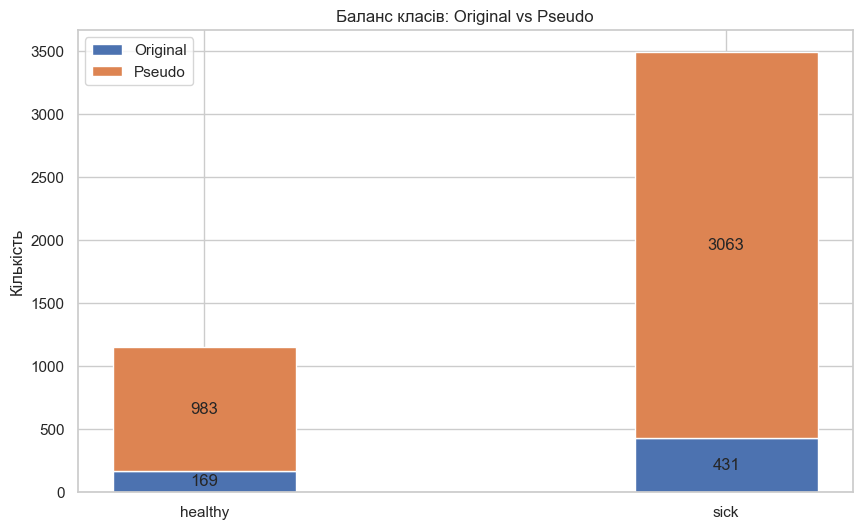

In [ ]:
# Клас для псевдо-датасету (щоб об'єднати з Train)
class PseudoDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

if len(pseudo_imgs) > 0:
    pseudo_dataset_obj = PseudoDataset(pseudo_imgs, pseudo_lbls)
    
    # Об'єднуємо Original Train + Pseudo
    extended_train_dataset = ConcatDataset([image_datasets['train'], pseudo_dataset_obj])
    
    print(f"📏 Розмір оригінального Train: {len(image_datasets['train'])}")
    print(f"📏 Розмір розширеного Train: {len(extended_train_dataset)}")
    
    # Аналіз нового балансу
    # Рахуємо оригінальні
    orig_counts = get_class_distribution(image_datasets['train'])
    # Рахуємо псевдо
    pseudo_counts = {c: 0 for c in class_names}
    for l in pseudo_lbls:
        pseudo_counts[class_names[l]] += 1
        
    # Візуалізація
    labels = class_names
    orig_vals = [orig_counts[c] for c in labels]
    pseudo_vals = [pseudo_counts[c] for c in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, orig_vals, width, label='Original')
    rects2 = ax.bar(x, pseudo_vals, width, bottom=orig_vals, label='Pseudo')
    
    ax.set_ylabel('Кількість')
    ax.set_title('Баланс класів: Original vs Pseudo')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    ax.bar_label(rects1, label_type='center')
    ax.bar_label(rects2, label_type='center')
    
    plt.show()
    
else:
    print("⚠️ Не знайдено зображень вище порогу. Пропускаємо етап розширення.")
    extended_train_dataset = image_datasets['train']

In [ ]:
# Створюємо DataLoader для розширеного набору
extended_train_loader = DataLoader(extended_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Оновлюємо словник loaders (замінюємо train на extended)
dataloaders_pseudo = {
    'train': extended_train_loader,
    'val': dataloaders['val'] # Валідація залишається тією ж!
}

# Ініціалізуємо Model v2 (копія v1 або нова)
# Варіант А: Продовжити навчання поточної моделі
print("🔄 Продовжуємо навчання моделі на розширених даних...")
model_v2 = copy.deepcopy(model_v1) # Починаємо з точки, де зупинилась v1
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=LR * 0.1) # Зменшуємо LR для тонкого налаштування

# Навчання v2
model_v2, history_v2 = train_model(
    model_v2, 
    dataloaders_pseudo, 
    criterion, 
    optimizer_v2, 
    num_epochs=EPOCHS_PSEUDO
)

🔄 Продовжуємо навчання моделі на розширених даних...
Epoch 1/10
----------


In [ ]:
plot_training_history(history_v2, "Semi-Supervised Model v2")

In [ ]:
_ = evaluate_model(model_v2, dataloaders_pseudo['train'], class_names, "Extended Train Set (Model v2)")

In [ ]:
print("🏁 Фінальна оцінка Model v2 на Test Set...")
metrics_v2 = evaluate_model(model_v2, dataloaders['test'], class_names, "Test Set (Model v2)")

# --- Порівняльна візуалізація ---
metric_names = ['Accuracy', 'F1 Score']
v1_scores = [metrics_v1['acc'], metrics_v1['f1']]
v2_scores = [metrics_v2['acc'], metrics_v2['f1']]

x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, v1_scores, width, label='Baseline (v1)', color='gray')
rects2 = ax.bar(x + width/2, v2_scores, width, label='Pseudo-labeling (v2)', color='green')

ax.set_ylabel('Scores')
ax.set_title('Порівняння ефективності: Baseline vs Semi-Supervised')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylim([0, 1.1])
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

plt.show()

# Висновок текстом
diff_acc = metrics_v2['acc'] - metrics_v1['acc']
diff_f1 = metrics_v2['f1'] - metrics_v1['f1']

print("=== ВИСНОВОК ДОСЛІДЖЕННЯ ===")
print(f"Зміна Accuracy: {diff_acc:+.4f}")
print(f"Зміна F1-score: {diff_f1:+.4f}")

if diff_f1 > 0:
    print("✅ Псевдолейблінг покращив результат!")
else:
    print("⚠️ Псевдолейблінг не дав приросту або погіршив результат. Можливі причини: шумні псевдолейбли, замало даних, високий поріг.")